# Motivation 

In October 2019 Canadians went to polls to vote for Prime Minister. The 10 months that preceed the voting were marked by polytical campaigning and by many releases from the press. This post has as goal to show how you can use a machine learning technique to verify if a press article has any bias (polytical or others but in this case we are testing polytical bias.

All of the files for this project can be found in the Github repository here: https://github.com/dresenhista/canada_election2019

## Assumptions and Preparation
To simplify our calculations, I am only using Canada's top 3 parties:
 - Conservative Party
 - Liberal Party
 - New Democratic Party.
 
I also have a separate script to scrap the website of the three parties above as well as any random press release from any main Canadian newspaper and collect their presses releases. Such script can be found in the Github repo for this project.

There are tons of really good articles explaining what Naive Bayes is, how it is applied and how to calculate the probability (my favourite is this one: https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) thus I will not spend too much time explaining the logic behind. Instead I will focus on explaining how I leveraged the methodology to this problem.

My solution can be split into 3 main stages:

1. Train a model using press releases from the political parties.
2. Validate the model using press releases from political parties not used in the training section.
3. Predict political preference/tone of a newspaper article using the model above. 

# Methodology
The methodology is something very simple in statiscal modeling (and some would say even too simple), I will be using Naive Bayes to train the model and predict the probability of a press release being either one of the.

**Naive Bayes** relies on Bayes probability to classify objects. We call these types of models in Statistics of pobabilitics classifiers. This is also a supervised model, which means that it needs to be trained or you need to have the real labels before you start the model. 

## Libraries used in the modeling part

You will need to load the following libraries in your python/jupyter notebook file, I added why you need each one of them :): 

In [23]:
import pandas as pd #data manipulation
import numpy as np #main math calculation
import sklearn #modeling load
import nltk #to tokenize the words
from nltk.corpus import stopwords # to remove useless words to the model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer #count words when press releases are made into vectors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder #transform the labels
from sklearn.naive_bayes import MultinomialNB #Naive Bayes fitter
from sklearn.metrics import confusion_matrix #calculate confusion matrix
import scikitplot as skplt #plot confusion matrix

import warnings #remove warnings
warnings.filterwarnings('ignore')

## Data Preparation

The data used in this file comes from the script run in [this repo](http://localhost:8888/notebooks/election2019/scrapper/canadian_party_pr_scraper.ipynb).

First let's load the dataset and see how it looks like:

In [37]:
df = pd.read_csv('canada_parties_pr.csv')
df.head()

,party,url,content,date
0,conservative,https://www.conservative.ca/the-hon-andrew-sch...,"\r\nFOR IMMEDIATE RELEASE\r\nOttawa, ON – The ...",2019-07-11
1,conservative,https://www.conservative.ca/justin-trudeau-mus...,"\r\nFOR IMMEDIATE RELEASE\r\n\r\nTORONTO, ON\r...",2019-07-11
2,conservative,https://www.conservative.ca/justin-trudeaus-ba...,"\r\nFOR IMMEDIATE RELEASE\r\nOTTAWA, ON – Pier...",2019-05-28
3,conservative,https://www.conservative.ca/conservatives-to-s...,\r\nNew conservative government to extend EI p...,2019-10-15
4,conservative,https://www.conservative.ca/andrew-scheer-reve...,\r\nConservatives unveil fully costed platform...,2019-10-11


In the dataframe above we need to remove the words that do not add anything to the setence, for example, words such as "a, the, punctuations like ; and , also need to remove. And we are interested in two columns: party and content. Those will be the only columns that will be used to train our machine learning algorithm.
After that we will need to separate the dataframe above into two sets: training and testing.
This is what the code below does:

In [38]:
#function that tokenize a sentence and remove stop words
def sentence_to_word(df, column_name, stop):
    
    #lower case
    df[column_name] = df[column_name].apply(lambda string: string.lower())
    df['words'] = df[column_name].apply(nltk.word_tokenize)
    df['words'] = df['words'].apply(lambda x: [item for item in x if item not in stop])
    df['words'] = df['words'].apply(lambda x: [item for item in x if item.isalpha()])
    
    return df

#define the stop words
stop_extra = ['*', '#', '?', '$', '!', '&',  '%', '\'','\'ll', '"','\'\'' '\'m', '\'re', '\'ve', '(', ')', '\'s', '-', '--']
stop = stopwords.words('english') + stop_extra
df = sentence_to_word(df, 'content', stop)

#select the columns we mentioned before. 
#Here we are calling labels as y because this is what we want to predict
#X is content because this is supposedly what it is given to us.
y = df['party']
X = df['content']

#separate test and training
# we are choosing 80% to training and 20% to testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now we have both datasets looking exactly like what we need. 

## Data Modeling

The first thing the algorithm will do is in the **training set** count #number of press releases per political party as well as the total #of press releases. Then it will count the #of times that each word shows per political party and the #of words per party.

That will be used to calculate the Bayes probability in the function below:

-- In the training set we calculate 
<center>
    \begin{align}
    \\ P(X \cap Y) = P(X| Y=y) P(Y)
    \end{align}
</center>

Which can be translated into:

<center>
    \begin{align}
    \\ P(content \cap political party Y) = P(content| Party=y) P(party)
    \end{align}
</center>

Where:


\begin{equation*}
\\P(content | Party) = \frac{number\_the\_word\_shows\_by\_party}{total\_words\_by\_party} 
\end{equation*}

\begin{equation*}
\\P(Party) = \frac{post\_release\_by\_party}{total\_post\_release} 
\end{equation*}


And last but not least We will also tokenize the words. Tokenize is the process of getting a sentence, or writing passage and breaking into a vector of words. 

In [48]:
#tokenize the words in the content
vect = CountVectorizer()
X_train_vectorized = vect.fit_transform(X_train)
ndf = pd.SparseDataFrame(
    X_train_vectorized.toarray(), columns=vect.get_feature_names()
)

Now we are ready **to train** the model:

In [49]:
#apply pre made model
clfrNB = MultinomialNB()
clfrNB = clfrNB.fit(X_train_vectorized, y_train)

## Model Validation
As I mentioned before, modeling a supervised type pf machine learning modeling invovles two steps, training and testing. Now we need to test if the probabilities calculated above are good predictors of data never seen before.

At this point you might have asked yourselve the two questions below:

### Why is this model called Naive Bayes?

The reason why this method is called naive is because it considers the words independent of each other, ie., there is no bias or tendency of words showing up more when other words are present in a determined content, which we know that is not true.

### What if a word that was not present in the training set shows up in the testing set?
In the article that I added in this document, it touches on what to do in these cases, to simplify this model, I decided to use ***Laplace Smoother***. This method addes a value (1/ # unique words) to each probability which solves the fact that some words were never seen in the training set. 

Now we need to apply the training model to the test:

In [50]:
y_pred = clfrNB.predict(vect.transform(X_test))

And this is how I like to visualize. The plot below is called confusion matrix and it evaluates the real versus the predicted. From 101 press releases in the testing set, the model only misses 5, which is really good!!!

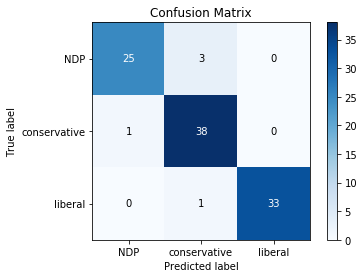

In [51]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred);

# Ta-dã moment
Now we upload an article that relates to polytics and see if it has a Liberal, Conservative or NDP tone to it:

This is the article that I choose, but you can use the function below to retrieve it: https://www.thestar.com/news/canada/2020/04/18/canada-among-13-countries-uniting-to-demand-global-co-operation-russia-reports-biggest-increase-in-cases-spain-becomes-third-country-to-report-over-20000-virus-deaths.html

In [52]:
#for scraping
import requests
from bs4 import BeautifulSoup
#add data as dataframe and make math calculations
import pandas as pd



#article you want to test:
webpage = 'https://www.thestar.com/news/canada/2020/04/18/canada-among-13-countries-uniting-to-demand-global-co-operation-russia-reports-biggest-increase-in-cases-spain-becomes-third-country-to-report-over-20000-virus-deaths.html'
response = requests.get(webpage)
soup = BeautifulSoup(response.text, 'lxml')
class_name='.text-block-container'

#gets all the content
article = ''
for text in soup.select(class_name):
    article  += text.get_text()

article_df =  pd.DataFrame(data= {'article':[article]})

You need to tokenize the hold out data and call the same vectorized function used in the training **if you don't do this you won't have the same features in the holdout**

In [54]:
#tokenize the words in the content

X_validation = vect.transform(article_df["article"])

ndf = pd.SparseDataFrame(
    X_validation.toarray(), columns=vect.get_feature_names()
)

In [59]:
#calls the Naive Bayes trained model:
y_pred = clfrNB.predict(X_validation)
print(f'The Article has a tone closer to this party: {y_pred}')

The Article has a tone closer to this party: ['NDP']
